<a href="https://colab.research.google.com/github/SHUBHAMshetmandrekar/Facial_Expression_Recognition/blob/main/Facial_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload the dataset (zip file)


Saving Emotion Detection.zip to Emotion Detection.zip


In [ ]:
import zipfile
import os

with zipfile.ZipFile('Emotion Detection.zip', 'r') as zip_ref: #unzipping
    zip_ref.extractall('Emotion Detection')


In [ ]:
train_dir = 'Emotion Detection/train'
test_dir = 'Emotion Detection/test'


# ImageDataGenerator for Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = 48
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


# CNN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Fully connected
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))  # 7 emotion classes


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Compile and Train

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import class_weight
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint

# Save the model with the best validation loss
checkpoint = ModelCheckpoint(
    'Emotion_model.keras',       # Filename to save
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,       # Save full model
    verbose=1
)

# Early stopping to avoid overfitting
early_stop = EarlyStopping(
    monitor='val_loss',  # You can also use 'val_accuracy'
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Reduce learning rate when val_loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr, checkpoint],
)


Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4566 - loss: 1.3934
Epoch 1: val_loss improved from inf to 1.31652, saving model to Emotion_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 43s 75ms/step - accuracy: 0.4566 - loss: 1.3934 - val_accuracy: 0.5068 - val_loss: 1.3165 - learning_rate: 0.0010
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4538 - loss: 1.3918
Epoch 2: val_loss improved from 1.31652 to 1.22998, saving model to Emotion_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.4539 - loss: 1.3918 - val_accuracy: 0.5359 - val_loss: 1.2300 - learning_rate: 0.0010
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4766 - loss: 1.3536
Epoch 3: val_loss improved from 1.22998 to 1.21335, saving model to Emotion_model.keras
449/449 ━━━━━━━━━━━━━━━━━━━━ 28s 61ms/step - accuracy: 0.4766 - loss: 1.3536 - val_accuracy: 0.5564 - val_loss: 1.2134 - learning_rate: 0.0010
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/st

# Load and run

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('Emotion_model.keras')

# Define emotion labels (ensure order matches your training generator class indices)
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


In [ ]:
print(test_generator.class_indices)


{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


In [ ]:
print(train_generator.class_indices)


emotion_labels = list(train_generator.class_indices.keys())


{'angry': 0, 'disgusted': 1, 'fearful': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprised': 6}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


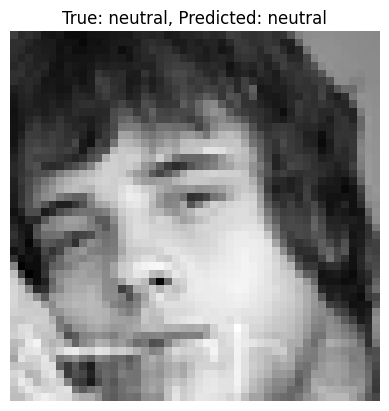

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of test images and labels
images, labels = next(test_generator)

# Pick one image from the batch
idx = np.random.randint(0, len(images))
img = images[idx]
true_label = np.argmax(labels[idx])

# Predict
prediction = model.predict(np.expand_dims(img, axis=0))
predicted_label = np.argmax(prediction)

# Show result
plt.imshow(img.squeeze(), cmap='gray')
plt.title(f"True: {emotion_labels[true_label]}, Predicted: {emotion_labels[predicted_label]}")
plt.axis('off')
plt.show()


In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         1,79

 Total params: 10,523,991 (40.15 MB)

 Trainable params: 3,507,399 (13.38 MB)

 Non-trainable params: 1,792 (7.00 KB)

 Optimizer params: 7,014,800 (26.76 MB)

# Confusion Matrix

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and predictions
y_true = []
y_pred = []

# Loop through test batches
for i in range(len(test_generator)):
    images, labels = test_generator[i]
    preds = model.predict(images)

    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
2/2 ━━━━━━━

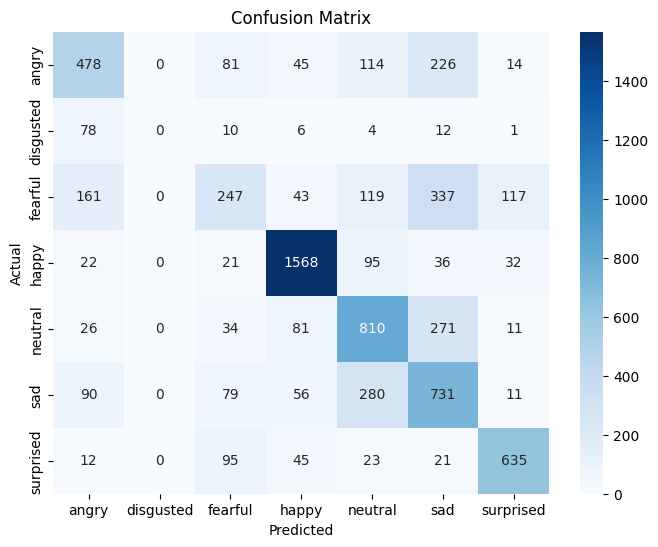

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

emotion_labels = list(test_generator.class_indices.keys())
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=emotion_labels, yticklabels=emotion_labels, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
print(classification_report(y_true, y_pred, target_names=emotion_labels))


              precision    recall  f1-score   support

       angry       0.55      0.50      0.52       958
   disgusted       0.00      0.00      0.00       111
     fearful       0.44      0.24      0.31      1024
       happy       0.85      0.88      0.87      1774
     neutral       0.56      0.66      0.60      1233
         sad       0.45      0.59      0.51      1247
   surprised       0.77      0.76      0.77       831

    accuracy                           0.62      7178
   macro avg       0.52      0.52      0.51      7178
weighted avg       0.61      0.62      0.61      7178



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Saving PrivateTest_14433751.jpg to PrivateTest_14433751.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step


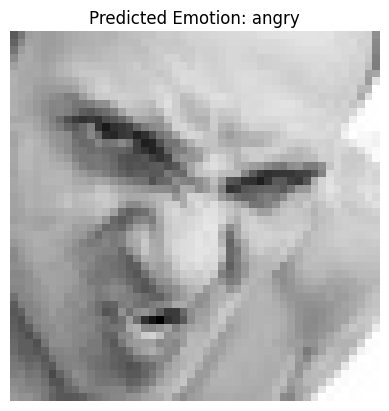

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

# Upload image at runtime
from google.colab import files  # if using Google Colab
uploaded = files.upload()       # This opens a file picker in Colab

# Load the model
model = load_model('Emotion_model.keras')

# Emotion labels (update to match your model)
emotion_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# Process the uploaded image
for file_name in uploaded.keys():
    img = Image.open(io.BytesIO(uploaded[file_name])).convert('L')  # 'L' for grayscale
    img = img.resize((48, 48))  # Resize to match your model input
    img_array = np.array(img).reshape(1, 48, 48, 1) / 255.0

    # Predict
    prediction = model.predict(img_array)
    predicted_class = emotion_labels[np.argmax(prediction)]

    # Display
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted Emotion: {predicted_class}")
    plt.axis('off')
    plt.show()


# Model to Test Colored images

Saving cropped_emotions.6213.png to cropped_emotions.6213.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 616ms/step


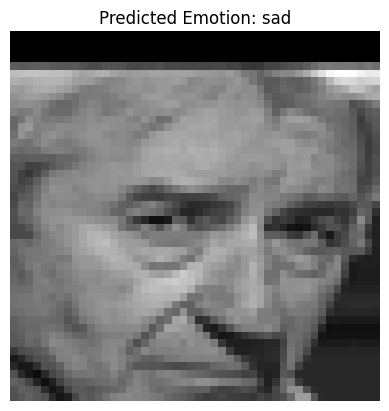

In [5]:
from tensorflow.keras.models import load_model
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import io

# Load trained model
model = load_model("Emotion_model.keras")

# Class labels (Make sure this matches your training labels)
emotion_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# Upload image
uploaded = files.upload()

for file_name in uploaded.keys():
    img = Image.open(io.BytesIO(uploaded[file_name]))

    # ✅ Convert to grayscale
    img = img.convert("L")

    # ✅ Resize to match model input
    img = img.resize((48, 48))

    # ✅ Convert to array and normalize
    img_array = np.array(img).astype('float32') / 255.0
    img_array = img_array.reshape(1, 48, 48, 1)

    # ✅ Predict
    prediction = model.predict(img_array)
    predicted_label = emotion_labels[np.argmax(prediction)]

    # ✅ Show result
    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted Emotion: {predicted_label}")
    plt.axis('off')
    plt.show()


# Interface

In [2]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.7 MB/s eta 0:00:00


In [3]:
from tensorflow.keras.models import load_model
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import io

# Load trained model
model = load_model("Emotion_model.keras")

# Class labels (Make sure this matches your training labels)
emotion_labels = ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

# Upload image
uploaded = files.upload()

import gradio as gr

def predict_emotion(image):
    img = image.convert("L").resize((48, 48))
    img_array = np.array(img).astype('float32') / 255.0
    img_array = img_array.reshape(1, 48, 48, 1)

    prediction = model.predict(img_array)
    predicted_label = emotion_labels[np.argmax(prediction)]
    return predicted_label

# Launch Gradio interface
gr.Interface(
    fn=predict_emotion,
    inputs=gr.Image(type="pil"),
    outputs="label",
    title="Facial Emotion Detector",
    description="Upload a face image and get the predicted emotion!"
).launch()


Saving 0a20d1b0827dc1b274677465e7d04807c9cbd85ca476675aa035a78ef.png to 0a20d1b0827dc1b274677465e7d04807c9cbd85ca476675aa035a78ef.png
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e4a557730f42a19790.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
